# Flight delay prediction
## 1.Exporation notebook

First exploration of the data. dat set available [here](https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236&DB_Short_Name=On-Time). We extract the following feature for year 2016: 'YEAR', 'MONTH', 'DAY_OF_WEEK', 'FL_DATE', 'OP_UNIQUE_CARRIER','TAIL_NUM', 'ORIGIN_CITY_NAME', 'DEST_CITY_NAME', 'CRS_DEP_TIME', 'DEP_DELAY', 'CRS_ARR_TIME', 'ARR_DELAY', 'CANCELLED', 'DISTANCE'.

The final goal is to create a linear model to predict flight delay.

In [48]:
# read the list of files 
import pandas as pd
import numpy as np
import glob
path =r'Dataset2/'      # use your path
allFiles = glob.glob(path + "/*.csv")   # Return a list (could be empty), with files associate with the corresponding path.

frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    print(file_)
    df = pd.read_csv(file_, error_bad_lines = False, header=0, index_col=None)
    list_.append(df)
frame = pd.concat(list_)
frame = frame.reset_index(drop=True)   # to avoid duplicate index (start to 0 at each file)

Dataset2\361409057_T_ONTIME_REPORTING.csv
Dataset2\361409057_T_ONTIME_REPORTING_1.csv
Dataset2\361409057_T_ONTIME_REPORTING_10.csv
Dataset2\361409057_T_ONTIME_REPORTING_11.csv
Dataset2\361409057_T_ONTIME_REPORTING_2.csv
Dataset2\361409057_T_ONTIME_REPORTING_3.csv
Dataset2\361409057_T_ONTIME_REPORTING_4.csv
Dataset2\361409057_T_ONTIME_REPORTING_5.csv
Dataset2\361409057_T_ONTIME_REPORTING_6.csv
Dataset2\361409057_T_ONTIME_REPORTING_7.csv
Dataset2\361409057_T_ONTIME_REPORTING_8.csv
Dataset2\361409057_T_ONTIME_REPORTING_9.csv


In [49]:
frame.head()

,YEAR,MONTH,DAY_OF_WEEK,FL_DATE,OP_UNIQUE_CARRIER,TAIL_NUM,ORIGIN_CITY_NAME,DEST_CITY_NAME,CRS_DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_DELAY,CANCELLED,DISTANCE,Unnamed: 14
0,2016,1,7,2016-01-03,F9,N935FR,"Denver, CO","Cedar Rapids/Iowa City, IA",1525,-1.0,1820,-5.0,0.0,692.0,NaN
1,2016,1,7,2016-01-03,F9,N935FR,"West Palm Beach/Palm Beach, FL","Denver, CO",700,44.0,929,19.0,0.0,1679.0,NaN
2,2016,1,7,2016-01-03,F9,N938FR,"Trenton, NJ","Raleigh/Durham, NC",1845,13.0,2015,-2.0,0.0,373.0,NaN
3,2016,1,7,2016-01-03,F9,N938FR,"Raleigh/Durham, NC","Trenton, NJ",2055,-1.0,2220,-5.0,0.0,373.0,NaN
4,2016,1,7,2016-01-03,F9,N938FR,"Trenton, NJ","Chicago, IL",1250,2.0,1420,20.0,0.0,693.0,NaN


In [50]:
# we select meaningfull variables 
selection = ['YEAR','MONTH','DAY_OF_WEEK','FL_DATE', 'OP_UNIQUE_CARRIER', 'TAIL_NUM', 'ORIGIN_CITY_NAME', 
             'DEST_CITY_NAME','CRS_DEP_TIME', 'CRS_ARR_TIME','DEP_DELAY','ARR_DELAY','DISTANCE', 'CANCELLED']
df = frame.loc[:,selection]
del frame
df.memory_usage().sum()/1000000

629.177776

C:\Users\ben\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Series.data is deprecated and will be removed in a future version
  


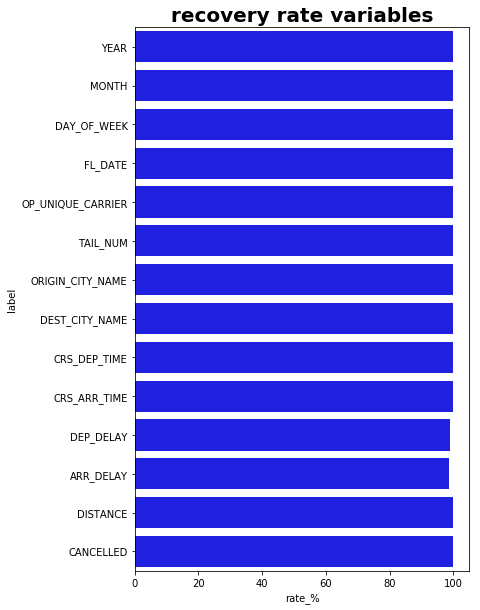

In [51]:
# recovery rate per feature
import matplotlib.pyplot as plt
import seaborn as sns

# inputs
buff = 100 - df.isnull().sum()/len(df) * 100
recovery = pd.DataFrame({"label": buff.index,
                         "rate_%" : buff.data})

# plot
plt.figure(figsize=(6,10))
plt.title("recovery rate variables", fontweight="bold", size = 20)
sns.barplot(x= "rate_%", y= "label", data=recovery, label="Total", color="b");

In [52]:
# list or Carriers with the total number of flight during the year 2016
df["OP_UNIQUE_CARRIER"].value_counts()

WN    1299444
DL     922746
AA     914495
OO     605933
UA     545067
EV     490990
B6     282473
AS     177280
NK     138199
F9      95121
HA      76789
VX      69121
Name: OP_UNIQUE_CARRIER, dtype: int64

## 1.1 Cleaning

In [53]:
# set negative delay to 0
mask = df["DEP_DELAY"] < 0
df.loc[mask,"DEP_DELAY"] = 0

mask = df["ARR_DELAY"] < 0
df.loc[mask,"ARR_DELAY"] = 0

In [54]:
# remove cancelled flight
mask =  df["CANCELLED"] == 0
a = len(df)
df = df.loc[mask,:]
b = len(df)
print("{} rows have been removed for cancelled flight ({}%)".format(a-b, round((a-b)/b*100 ),2))

65861 rows have been removed for cancelled flight (1%)


In [55]:
# remove month outlier
mask = ( df.loc[:,'MONTH'] > 12 )
df = df.loc[~mask,:]

In [56]:
# drop duplicat
a = len(df)
df = df.drop_duplicates()
b = len(df)
print("{} rows have been removed for duplicates ({}%)".format(a-b, round((a-b)/b*100),2))

0 rows have been removed for duplicates (0%)


In [57]:
# rename col
df = df.rename(index=str, columns={"OP_UNIQUE_CARRIER" : "CARRIER"})

In [58]:
# drop NaN
a = len(df)
try:
    df = df.dropna(subset=["ARR_DELAY", 'CARRIER','ORIGIN_CITY_NAME','DEST_CITY_NAME','CRS_DEP_TIME'])
except:
    print("No NaN value")
b = len(df)
print("{} rows have been removed for NaN ({}%)".format(a-b, round((a-b)/b*100),2))

13652 rows have been removed for NaN (0%)


## 1.2 Exploring

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df["HOURS"] = (df.loc[:,'CRS_DEP_TIME']/100).apply(np.floor)

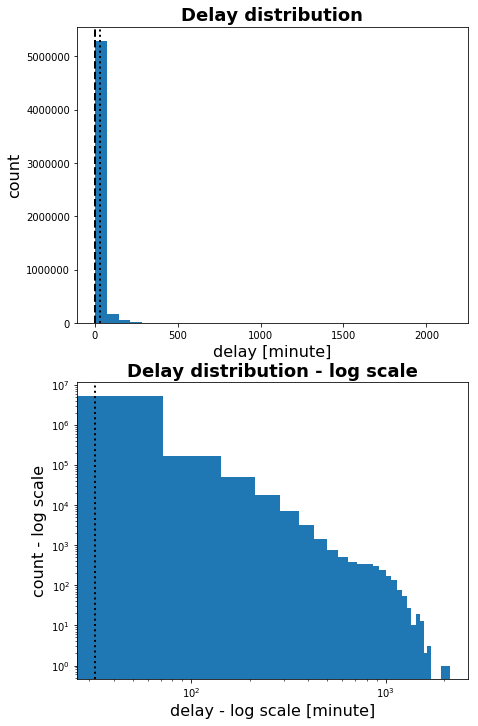

In [60]:
# delay distribution
import matplotlib.pyplot as plt

# inputs
y = df["ARR_DELAY"]

# plot
plt.figure(figsize=(7,12))

plt.subplot(2,1,1)
plt.title("Delay distribution", fontweight="bold", size = 18)
plt.hist(y, bins = 30, log = False)
plt.axvline(y.median(), color='black', linestyle='--', linewidth=2, label = "median")
plt.axvline(y.quantile(0.9), color='black', linestyle=':', linewidth=2, label = "P90")
plt.ylabel('count', size = 16)
plt.xlabel('delay [minute]', size = 16)

plt.subplot(2,1,2)
plt.hist(y, bins = 30, log = True)
plt.title("Delay distribution - log scale", fontweight="bold", size = 18)
plt.axvline(y.median(), color='black', linestyle='--', linewidth=2, label = "median")
plt.axvline(y.quantile(0.9), color='black', linestyle=':', linewidth=2, label = "P90")
plt.xscale('log')
plt.ylabel('count - log scale', size = 16)
plt.xlabel('delay - log scale [minute]', size = 16)

plt.show()

The distribution is very skew. It is good to notice that the median is 0, meaning than more than 50 percents are on time.

In [61]:
# what is frequency of on time flights ? 
qt = [(x, y.quantile(x/100)) for x in range(50, 100)]
pd.DataFrame(qt, columns = ("quantile","value")).sort_values(["value","quantile"], 
                                                             ascending = (True,False)).head(3)

,quantile,value
15,65,0.0
14,64,0.0
13,63,0.0


65% of the flight are on time.

In [62]:
# exreme delay quantile ? 
pd.DataFrame(qt, columns = ("quantile","value")).sort_values(["value","quantile"], ascending = (True,False)).tail(3)

,quantile,value
47,97,96.0
48,98,123.0
49,99,172.0


In [63]:
# we choose to remove the 2 perc extreme cases where delay above 123 min 
mask = df["ARR_DELAY"] < 123
a = len(df)
df = df.loc[mask,:]
b = len(df)
print("{} rows have been removed for the rare event where delay is above 100 minutes ({}%)".format(
    a-b, round((a-b)/b*100),2))

110772 rows have been removed for the rare event where delay is above 100 minutes (2%)


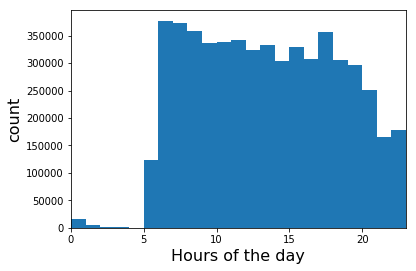

In [64]:
# flight distrubution along the day
plt.hist(df["HOURS"],bins = 23)
plt.ylabel('count', size = 16)
plt.xlabel("Hours of the day", size = 16)
plt.xlim(0,23)
plt.show()

We will focus our model to "standard" flights, with departure from 5:00 to 0:00 

In [65]:
# remove special flights before 5 a.m

mask = ( df.loc[:,'HOURS'] < 5 )

a = len(df)
df = df.loc[~mask,:]
b = len(df)
print("{} rows have been removed for Special flight before 5 a.m ({}%)".format(a-b, round((a-b)/b*100),1))


24532 rows have been removed for Special flight before 5 a.m (0%)


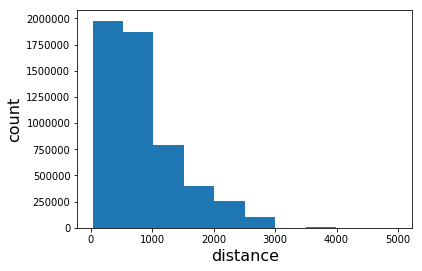

In [66]:
# distance
plt.hist(df["DISTANCE"])
plt.ylabel('count', size = 16)
plt.xlabel("distance", size = 16)
plt.show()

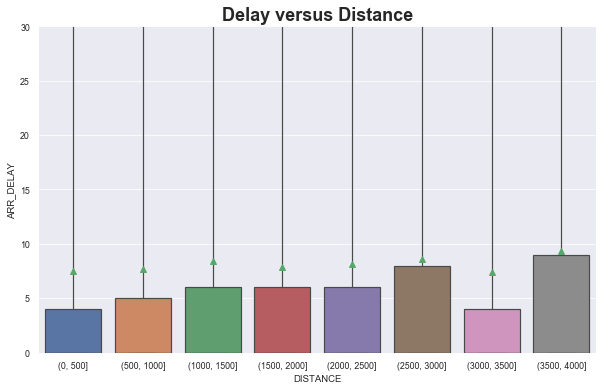

In [102]:
# delay versus distance

# input
x = df.loc[:,("DISTANCE","ARR_DELAY")]
zix = pd.cut(x["DISTANCE"],range(0,4500,500))

#plot
plt.figure(figsize=(10,6))
plt.title("Delay versus Distance", fontweight="bold", size = 18)
sns.boxplot(x=zix, y=x.loc[:,"ARR_DELAY"], showmeans=True, whis="range")   #, order = top2bot
plt.ylim(0,30)
plt.show()

No special relationship delay versus distance

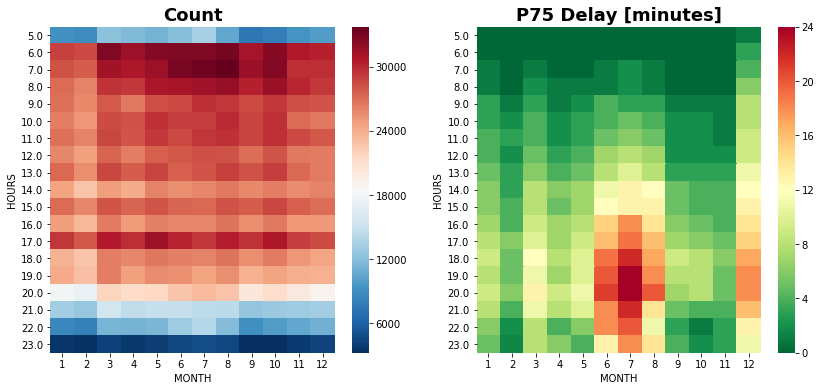

In [68]:
# Heatmaps: Hours versus Months

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.title("Count", fontweight="bold", size = 18)
x = df.loc[:,("MONTH","HOURS")].pivot_table(index='HOURS', columns='MONTH',  aggfunc=len, fill_value=0)
sns.heatmap(x, annot=False, cmap = "RdBu_r")

plt.subplot(1,2,2)
plt.title("P75 Delay [minutes]", fontweight="bold", size = 18)
x = df.loc[:,("ARR_DELAY","MONTH","HOURS")].pivot_table(values = "ARR_DELAY", 
                                                            index='HOURS', columns='MONTH',  
                                                            aggfunc= lambda x: np.percentile(x, 75), 
                                                            fill_value=0)
sns.heatmap(x, annot=False, cmap = "RdYlGn_r")
plt.show()

On the first graph, more flights are early in the morning and around 17:00 (maybe because of work related travel).  
On the second Graph, we can see that delay seems more important at the end of the day and also during the summer months (maybe because of holidays related travels:more "unexperienced" travelers for the same number of flights).

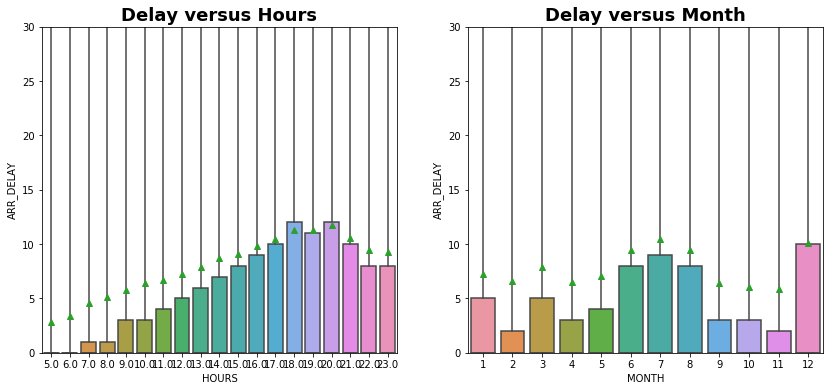

In [69]:
# boxplots: Delay versus hour and Month

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.title("Delay versus Hours", fontweight="bold", size = 18)
sns.boxplot(x="HOURS", y="ARR_DELAY", data=df,showmeans=True, whis="range")   #, order = top2bot
plt.ylim(0,30)

plt.subplot(1,2,2)
plt.title("Delay versus Month", fontweight="bold", size = 18)
sns.boxplot(x="MONTH", y="ARR_DELAY", data=df,showmeans=True, whis="range")   #, order = top2bot
plt.ylim(0,30)
plt.show()

On the first graph delays seem to accumulate in a linear manner along the day.  
On the second graph, high delay during summer months and also during december.
It is interting to see that the delay variation magnitude, along months or hours are in the same order (slightly higher for hours).

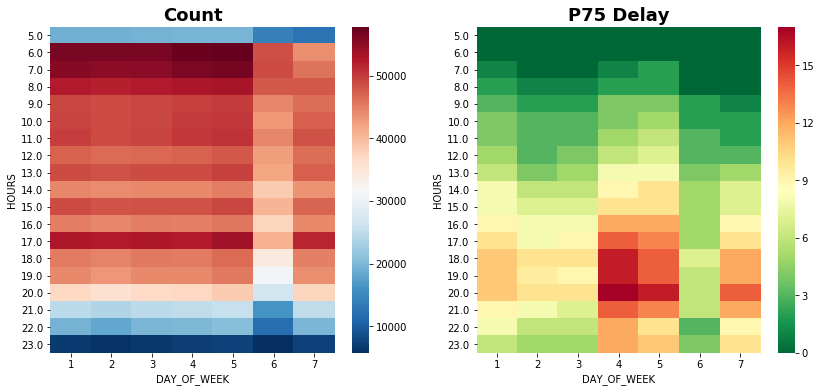

In [70]:
# Heatmaps: hours versus Week_Day

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.title("Count", fontweight="bold", size = 18)
x = df.loc[:,('DAY_OF_WEEK',"HOURS")].pivot_table(index='HOURS', 
                                                  columns='DAY_OF_WEEK',  
                                                  aggfunc=len, 
                                                  fill_value=0)
sns.heatmap(x, annot=False, cmap = "RdBu_r")

plt.subplot(1,2,2)
plt.title("P75 Delay", fontweight="bold", size = 18)
x = df.loc[:,("ARR_DELAY",'DAY_OF_WEEK',"HOURS")].pivot_table(values = "ARR_DELAY", 
                                                                  index='HOURS', 
                                                                  columns='DAY_OF_WEEK',  
                                                                  aggfunc= lambda x: np.percentile(x, 75), 
                                                                  fill_value=0)
sns.heatmap(x, annot=False, cmap = "RdYlGn_r")
plt.show()

On graph one, we can see that are less flighs on saturday.
On the second graph, high delay expected thursday and friday afternoon. Almost none the saturday.

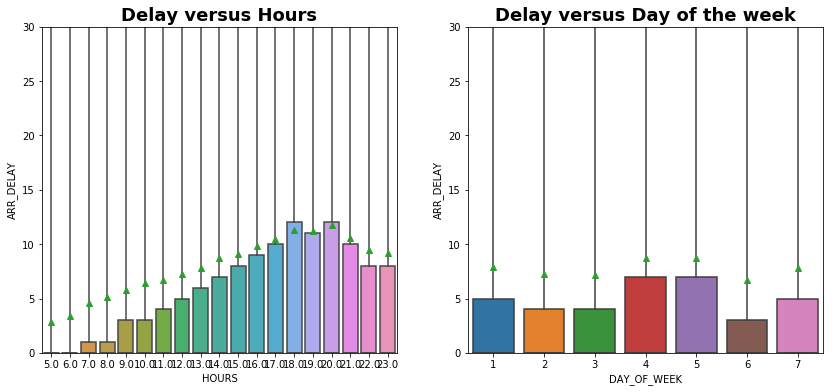

In [71]:
# boxplots: Delay versus hour and Month

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.title("Delay versus Hours", fontweight="bold", size = 18)
sns.boxplot(x="HOURS", y="ARR_DELAY", data=df,showmeans=True, whis="range")   #, order = top2bot
plt.ylim(0,30)

plt.subplot(1,2,2)
plt.title("Delay versus Day of the week", fontweight="bold", size = 18)
sns.boxplot(x="DAY_OF_WEEK", y="ARR_DELAY", data=df,showmeans=True, whis="range")   #, order = top2bot
plt.ylim(0,30)
plt.show()

Overall the delay variation on day of the week are lower than the hours of the day.

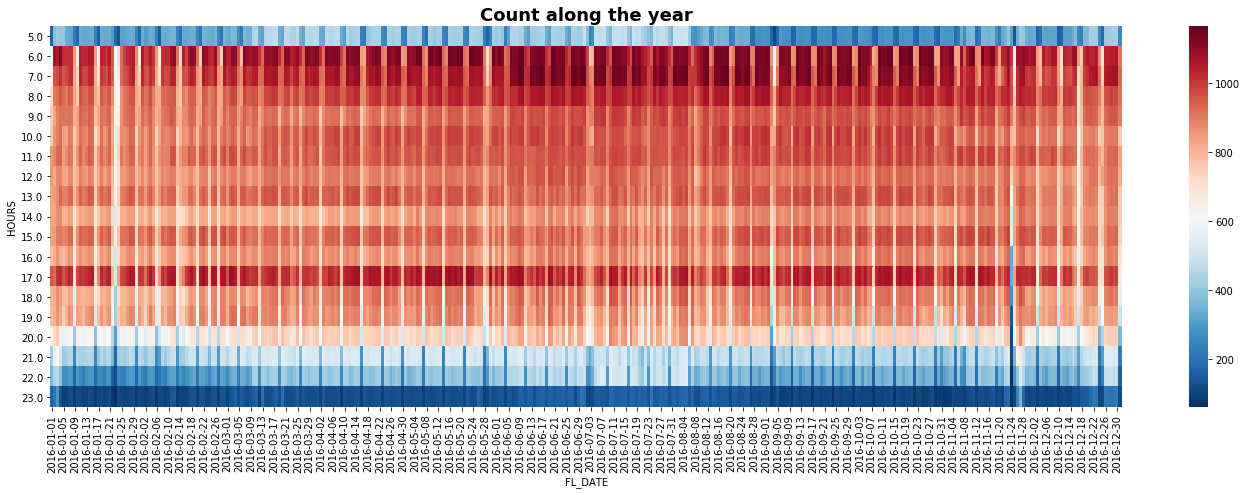

In [72]:
# flight along the year
plt.figure(figsize=(24,7))
plt.title("Count along the year", fontweight="bold", size = 18)
x = df.loc[:,('FL_DATE',"HOURS")].pivot_table(index='HOURS', columns='FL_DATE',  aggfunc=len, fill_value=0)
sns.heatmap(x, annot=False, cmap = "RdBu_r")
plt.show()

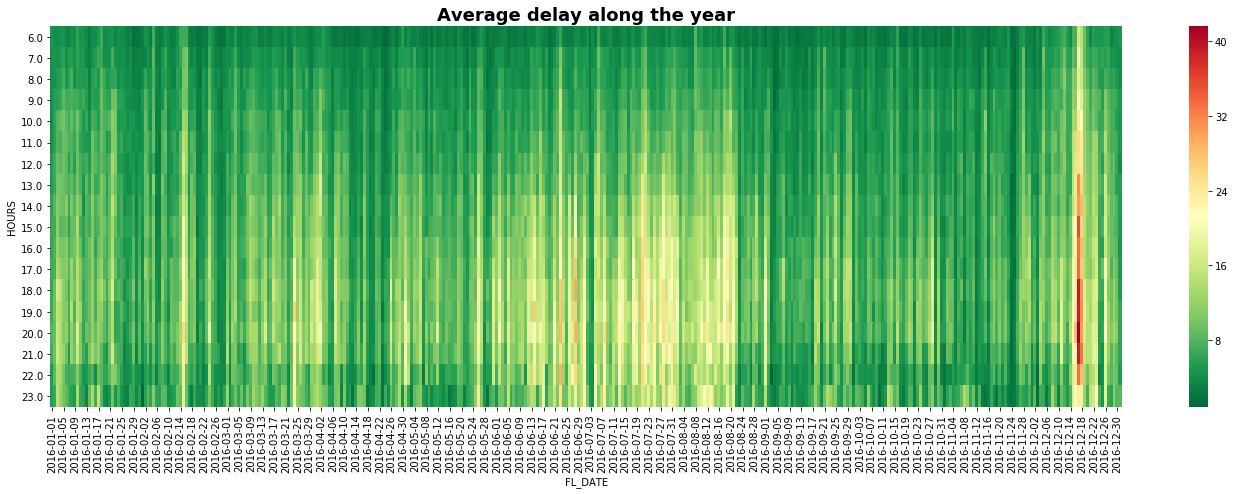

In [73]:
# delays along the years
plt.figure(figsize=(24,7))
plt.title("Average delay along the year", fontweight="bold", size = 18)
mask = df["HOURS"] > 5   # before 5 a.m few flights mess-up the color scheme.
x = df.loc[mask,("ARR_DELAY","FL_DATE","HOURS")].pivot_table(values = "ARR_DELAY", 
                                                             index='HOURS',
                                                             columns='FL_DATE',  
                                                             aggfunc= np.mean, 
                                                             fill_value=0)
sns.heatmap(x, annot=False, cmap = "RdYlGn_r")
plt.show()

Again, in a more detail version that summer higher delays. 
we can also so see some special days around the 15 Februray for the "Presidens day" and days around 14-18 december ([winter storm, 14-18 december 2016](https://www.nbcnews.com/news/weather/ridiculously-heavy-huge-winter-storm-makes-way-already-hurting-midwest-n696661)).
we could remove this periode, considering it a as an extreme event. However we will keep it, it somehow provide the information that heavy icing events can delay flights in winter. We will keep this point in mind when building our model.

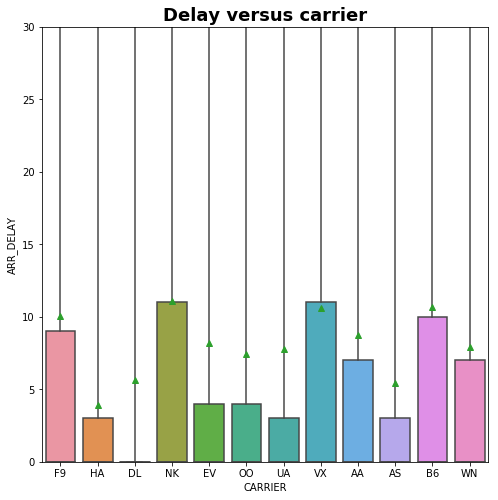

In [74]:
# Boxplot: delay distribution per carrier

# plot
plt.figure(figsize=(8,8))
plt.title("Delay versus carrier", fontweight="bold", size = 18)
sns.boxplot(x="CARRIER", y= "ARR_DELAY", data=df, whis="range", showmeans=True)   #, order = top2bot
plt.ylim(0,30)
plt.show()

In [75]:
# creation of late columns Bool that indicate if the flight if delay or note 
df["Late"] = 0
mask = df["ARR_DELAY"] > 0
df.loc[mask, "Late"] = 1

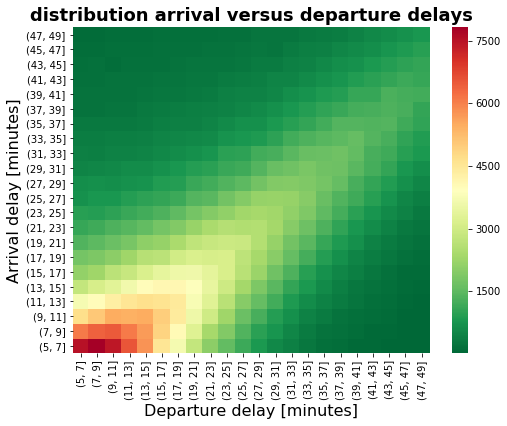

In [76]:
# heatmap distribution: departure versus arrival delays

# inputs
mask = df.loc[:,"Late"] == 1
x = df.loc[mask,("DEP_DELAY","ARR_DELAY")]
Dep_Del = pd.cut(x["DEP_DELAY"], list(range(5,50,2)),include_lowest=False)
Arr_Del = pd.cut(x["ARR_DELAY"], list(range(5,50,2)),include_lowest=False)


# plot
plt.figure(figsize=(8,6))
plt.title("distribution arrival versus departure delays", fontweight="bold", size = 18)
x = x.pivot_table(values = "ARR_DELAY", index= Arr_Del, columns=Dep_Del, aggfunc= len, fill_value=0)
sns.heatmap(x, annot=False, cmap = "RdYlGn_r")
plt.gca().invert_yaxis()
plt.ylabel("Arrival delay [minutes]", size = 16)
plt.xlabel("Departure delay [minutes]", size = 16)
plt.show()

Arrival delays is strongly linked to departure delay (linear relationship).
It is also interesting to notice the presence of a small shift, meaning that arrival delay are slightly lower than departure delays. Maybe this could be explain by the fact that pilote try to compensate the departure delay by going faster. However the final arrival delay is mainly explained by departure delay, and for this reason, we will focus more on the departure airports feature rather than the destination.

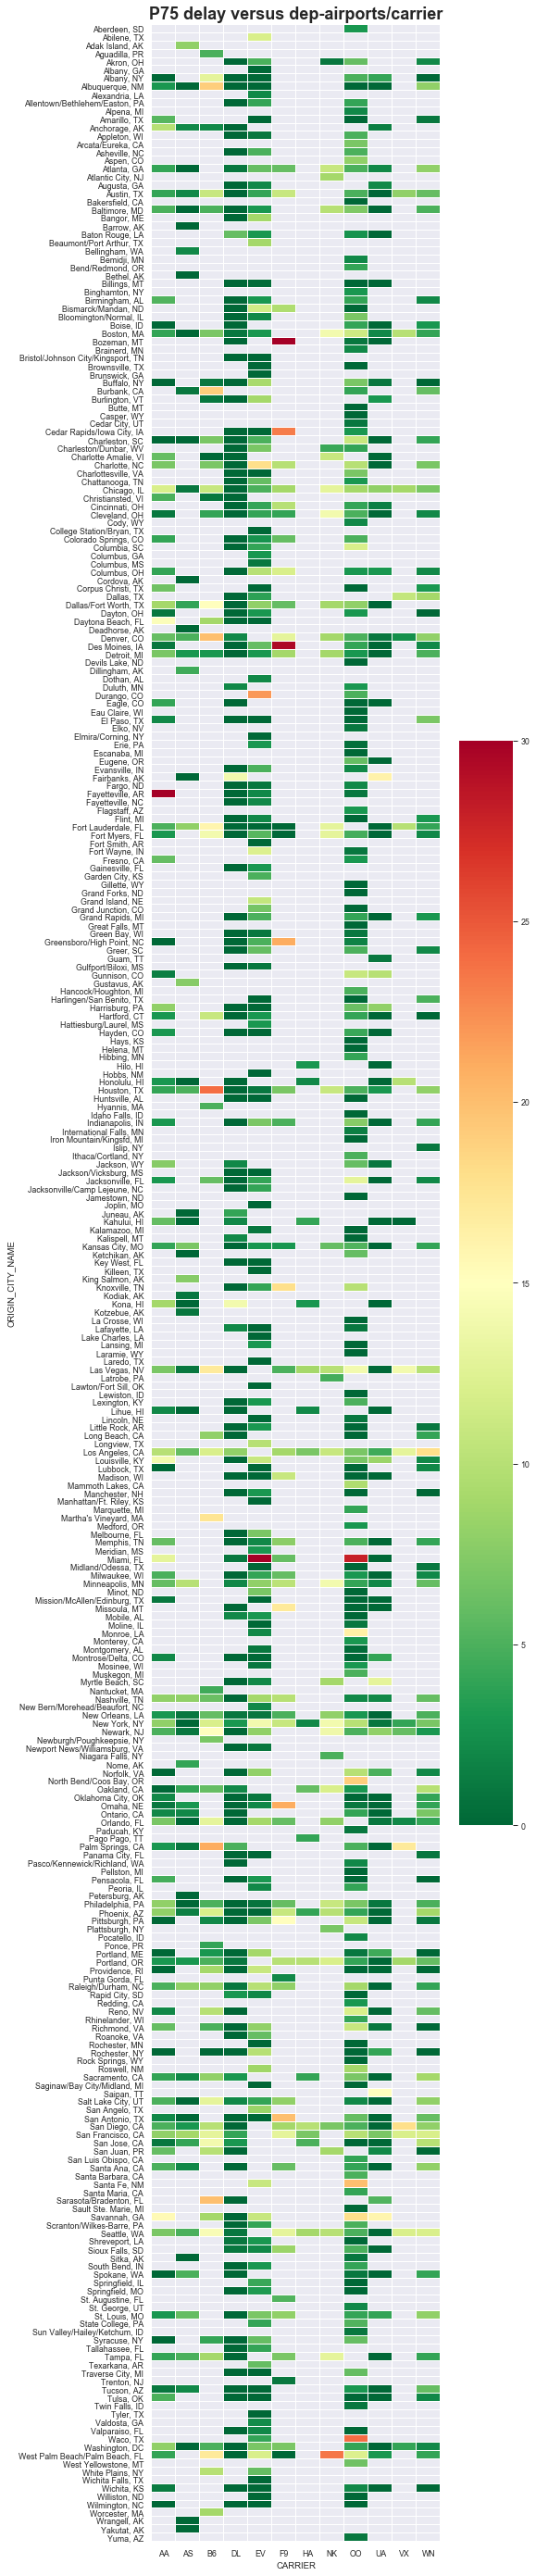

In [77]:
# Heatmap delay ~ departure airport, carrier

# inputs
x = df.loc[:,("ARR_DELAY","ORIGIN_CITY_NAME","CARRIER")].pivot_table(values = "ARR_DELAY", 
                                                                         index='ORIGIN_CITY_NAME', 
                                                                         columns='CARRIER',  
                                                                         aggfunc= lambda x: np.percentile(x, 75),
                                                                         fill_value=0)
count = df.loc[:,("ARR_DELAY","ORIGIN_CITY_NAME","CARRIER")].pivot_table(values = "ARR_DELAY", 
                                                                         index='ORIGIN_CITY_NAME', 
                                                                         columns='CARRIER',  
                                                                         aggfunc= lambda x: len(x),
                                                                         fill_value=0)
mask = count.loc[x.index,:] == 0     # strange count by default has 3 weird more index than x...should be the same

# plot
plt.figure(figsize=(7,50))
sns.set(context="paper")
plt.title("P75 delay versus dep-airports/carrier", fontweight="bold", size = 18)
sns.heatmap(x, annot=False, cmap = "RdYlGn_r", mask = mask, vmax= 30, linewidths=0.01)
plt.show()

### 1.3 Feature engineering

To use the airport information in our model we will create a new variable based on Airport. We start with the size of the airport.

In [78]:
city_size = df["ORIGIN_CITY_NAME"].value_counts()
city_avg_delay = df.groupby(by = "ORIGIN_CITY_NAME")["ARR_DELAY"].mean()

df["city_size"] = 0
z = city_size.to_frame().join(city_avg_delay)
z = z.rename(index=str, columns={"ORIGIN_CITY_NAME" : "Airport_Size"})
z.index.name = "Airports"
z.head()

,Airport_Size,ARR_DELAY
Airports,,
"Atlanta, GA",375158,6.623271
"Chicago, IL",317711,9.450941
"Denver, CO",217191,8.124420
"Los Angeles, CA",202556,9.950483
"Dallas/Fort Worth, TX",188550,9.671313


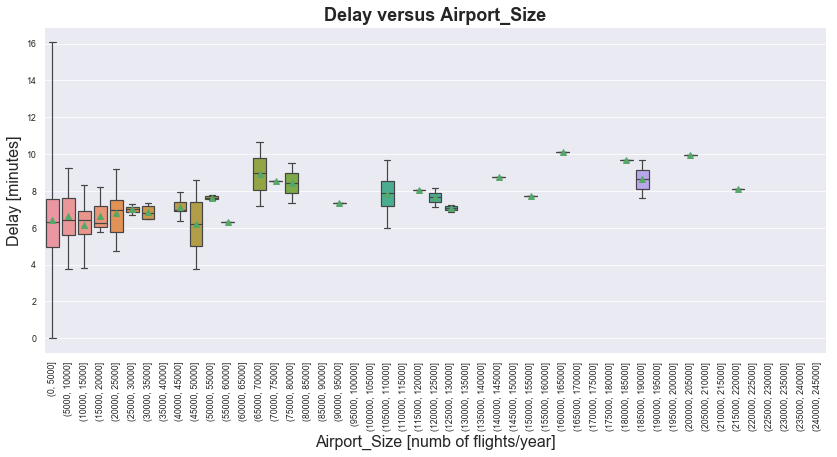

In [100]:
# Boxplot:  Delay versus airport size

# input
zix = pd.cut(z["Airport_Size"],range(0,250000,5000))

# plot
plt.figure(figsize=(14,6))
plt.xticks(rotation=90)
plt.title("Delay versus Airport_Size", fontweight="bold", size = 18)
sns.boxplot(x=zix, y=z.loc[:,"ARR_DELAY"], showmeans=True, whis="range") 
plt.xlabel("Airport_Size [numb of flights/year]", size = 16)  
plt.ylabel("Delay [minutes]", size = 16)
plt.show()

It seems that aiports above ~50000 have slightly more delay than the ones below. We will choose 50000 for our limit to define big airports. (Note that 60000 could also be a good choice).

In [79]:
# creat "big airport" feature, = 1 if size above 50000 flights a year , = 0 otherwise
mask = z["Airport_Size"] > 50000
z["Big_Airport"] = 0
z.loc[mask,"Big_Airport"] = 1

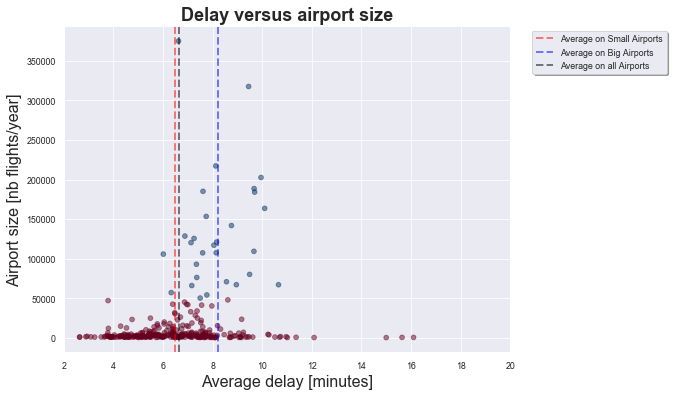

In [36]:
# Scatter:  Delay versus airport size
plt.figure(figsize=(8,6))
plt.title("Delay versus airport size", fontweight="bold", size = 18)
plt.scatter(z["ARR_DELAY"], z["Airport_Size"], c = z["Big_Airport"], alpha = 0.5, cmap='RdBu', label = "")

plt.axvline(z.groupby("Big_Airport").ARR_DELAY.mean()[0], linestyle='--', 
            linewidth=2, label = "Average on Small Airports", c = "Red", alpha = 0.5)

plt.axvline(z.groupby("Big_Airport").ARR_DELAY.mean()[1], linestyle='--', 
            linewidth=2, label = "Average on Big Airports", c = "Blue", alpha = 0.5)

plt.axvline(z["ARR_DELAY"].mean(), color='black', linestyle='--', 
            linewidth=2, label = "Average on all Airports", alpha = 0.5)

plt.legend(loc='upper center', bbox_to_anchor=(1.2, 1), fancybox=True, shadow=True, ncol=1)
plt.xlim(2,20)
plt.xlabel("Average delay [minutes]", size = 16)
plt.ylabel("Airport size [nb flights/year]", size = 16)

plt.show()

No obvious linear relationship but a significative difference on average delay beetween big and small airports. So, we will use the category "big airport" features rather than the numerical size of each airports.

In [37]:
# adding big_airport feature to the main DataFrame (df)
mask = z["Big_Airport"] == 0
small_airports = list(z.loc[mask].index)

df["Big_Airport"] = 1     # ~70% of the flights
for airport_name in small_airports:
    # print(airport_name)
    mask = df["ORIGIN_CITY_NAME"] == airport_name
    df.loc[mask,"Big_Airport"] = 0

In [41]:
df.loc[:,"DISTANCE":].head(5)

,DISTANCE,CANCELLED,HOURS,Late,city_size,Big_Airport
0,692.0,0.0,15.0,0,0,1
1,1679.0,0.0,7.0,1,0,0
2,373.0,0.0,18.0,0,0,0
3,373.0,0.0,20.0,0,0,0
4,693.0,0.0,12.0,1,0,0


For categorical variable we will agregate some variable and create dummy variables.

In [42]:
# seasons
df["Season"] = "Winter"

spring = df["MONTH"].isin([3,4,5]) 
summer = df["MONTH"].isin([6,7,8]) 
autumn = df["MONTH"].isin([9,10,11]) 

df.loc[spring,"Season"] = "Spring"
df.loc[summer,"Season"] = "Summer"
df.loc[autumn,"Season"] = "Autumn"

In [43]:
# day of the week

df["Week_day"] = df["DAY_OF_WEEK"]

days = {1:"Monday",
        2:"Tuesday",
        3:"Wednesday",
        4:"Thursday",
        5:"Friday",
        6:"Saturday",
        7:"Sunday"}

df = df.replace({"Week_day": days})

In [44]:
# data frame for model inputs: HOURS + as dummy: CARRIER, Season, Week_day
model_features = pd.concat([df.loc[:,"ARR_DELAY"],df.loc[:,"HOURS"]], axis = 1)
model_features = pd.concat([model_features,pd.get_dummies(df.loc[:,"CARRIER"])], axis = 1)
model_features = pd.concat([model_features,pd.get_dummies(df.loc[:,"Season"])], axis = 1)
model_features = pd.concat([model_features,pd.get_dummies(df.loc[:,"Week_day"])], axis = 1)
model_features = pd.concat([model_features,df.loc[:,"Big_Airport"]], axis = 1)

In [45]:
model_features.head(5)

,ARR_DELAY,HOURS,AA,AS,B6,DL,EV,F9,HA,NK,...,Summer,Winter,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Big_Airport
0,0.0,15.0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,1
1,19.0,7.0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0
2,0.0,18.0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0
3,0.0,20.0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0
4,20.0,12.0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0


## 1.4 Export processed data dataset

In [46]:
model_features.to_csv("flight_model_var.csv")